In [1]:
# @title Setup code


!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable

import numpy as np
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import gym
import numpy as np
from IPython import display
from matplotlib import pyplot as plt

env = Maze()

%matplotlib inline

In [3]:
initial_state = env.reset()

# 環境を初期状態にし、エージェントがそれを観察できるようにする
print(initial_state)

(0, 0)


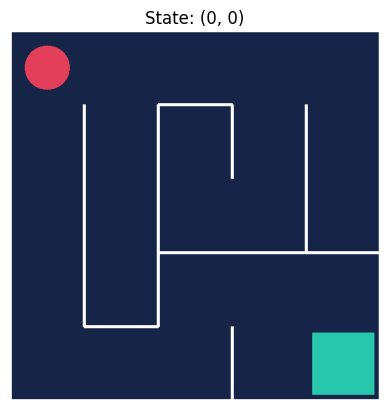

In [4]:
#環境の現在の状態を表すイメージをnp.ndarrayの形式で生成する。
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f'State: {initial_state}')
plt.imshow(frame)

In [5]:
# env.step() とは
# 　　Agentが選択したActionを環境に適用し、その環境を変更します
#  環境は4つのオブジェクトのタプルを返します:
#   - 次のState
#   - 獲得したReward
#   -　　taskが完了したか
#   -　　その他関連情報

action = 2 # 0: up 1: right 2:down 3:left
next_state, reward, done, info = env.step(action)
print(f"After moving down 1 row, the agent is in state: {next_state}")
print(f"After moving down 1 row, we got a reward of: {reward}")
print("After moving down 1 row, the task is", "" if done else "not", "finished")

After moving down 1 row, the agent is in state: (1, 0)
After moving down 1 row, we got a reward of: -1.0
After moving down 1 row, the task is not finished


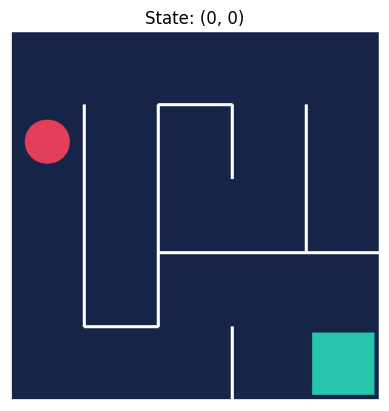

In [6]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f'State: {initial_state}')
plt.imshow(frame)

In [7]:
# タスクを完了し、環境を閉じ、関連リソースを解放する。
env.close()

# 迷路



In [8]:
env = Maze()

In [9]:
# Stateは2つの整数のtupleで構成され、いずれも[0, 4]の範囲にあり、Agentが現在いる行と列を表す：
print(f"For example, the initial state is: {env.reset()}")

# 観測できる空間（タスクで可能なすべての状態の集合）には25の要素（行と列の可能なすべての組み合わせ）がある：
# S = [(0, 0), (0, 1), (1, 0)....]
print(f"The space state is of type: {env.observation_space}")

For example, the initial state is: (0, 0)
The space state is of type: MultiDiscrete([5 5])


In [10]:
# Actionは0-3の4通り
# 0: up 1: right 2:down 3:left
print(f"An example of a valid action is: {env.action_space.sample()}")
print(f"The action state is of type: {env.action_space}")

An example of a valid action is: 2
The action state is of type: Discrete(4)


In [18]:
 # Trajectories and episoeds

state = env.reset()
trajectory = []

for _ in range(3):
  action = env.action_space.sample()
  next_state, reward, done, info = env.step(action)
  trajectory.append([state, action, reward, done, info, next_state])
  state = next_state

print(f"rejectory:\n{trajectory}")

rejectory:
[[(0, 0), 3, -1.0, False, {}, (0, 0)], [(0, 0), 2, -1.0, False, {}, (1, 0)], [(1, 0), 2, -1.0, False, {}, (2, 0)]]


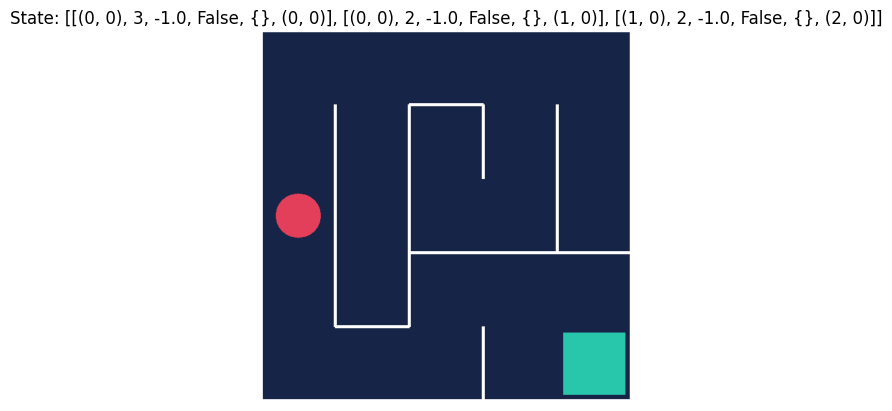

In [19]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f'State: {trajectory}')
plt.imshow(frame)

In [20]:
# episode(goal)まで実行
state = env.reset()
episode = []
done = False

while not done:
  action = env.action_space.sample()
  next_state, reward, done, info = env.step(action)
  trajectory.append([state, action, reward, done, info, next_state])
  state = next_state

print(f"rejectory:\n{trajectory}")

rejectory:
[[(0, 0), 3, -1.0, False, {}, (0, 0)], [(0, 0), 2, -1.0, False, {}, (1, 0)], [(1, 0), 2, -1.0, False, {}, (2, 0)], [(0, 0), 1, -1.0, False, {}, (0, 1)], [(0, 1), 0, -1.0, False, {}, (0, 1)], [(0, 1), 2, -1.0, False, {}, (1, 1)], [(1, 1), 3, -1.0, False, {}, (1, 1)], [(1, 1), 2, -1.0, False, {}, (2, 1)], [(2, 1), 0, -1.0, False, {}, (1, 1)], [(1, 1), 0, -1.0, False, {}, (0, 1)], [(0, 1), 1, -1.0, False, {}, (0, 2)], [(0, 2), 2, -1.0, False, {}, (0, 2)], [(0, 2), 1, -1.0, False, {}, (0, 3)], [(0, 3), 1, -1.0, False, {}, (0, 4)], [(0, 4), 3, -1.0, False, {}, (0, 3)], [(0, 3), 3, -1.0, False, {}, (0, 2)], [(0, 2), 3, -1.0, False, {}, (0, 1)], [(0, 1), 3, -1.0, False, {}, (0, 0)], [(0, 0), 3, -1.0, False, {}, (0, 0)], [(0, 0), 3, -1.0, False, {}, (0, 0)], [(0, 0), 0, -1.0, False, {}, (0, 0)], [(0, 0), 2, -1.0, False, {}, (1, 0)], [(1, 0), 0, -1.0, False, {}, (0, 0)], [(0, 0), 3, -1.0, False, {}, (0, 0)], [(0, 0), 2, -1.0, False, {}, (1, 0)], [(1, 0), 3, -1.0, False, {}, (1, 0)], 

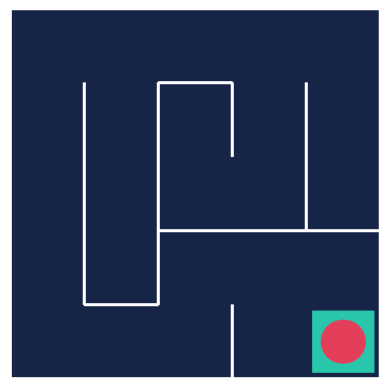

In [23]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(frame)

In [24]:
# rewards
state = env.reset()
action = env.action_space.sample()
_, reward, _, _ = env.step(action)

print(f"{reward=} {action=} {state=}")

reward=-1.0 action=1 state=(0, 0)


In [27]:
# return
state = env.reset()
episode = []
done = False
gamma = 0.99 # 割引価値
G_0 = 0 # return
t = 0 # time

while not done:
  action = env.action_space.sample()
  _, reward, done, _ = env.step(action)
  G_0 += gamma ** t * reward
  t +=1


print(
    f"""It took us {t} moves to find the exit,
    and each reward r(s,a)=-1, so the return amounts to {G_0}""")

It took us 1058 moves to find the exit,
    and each reward r(s,a)=-1, so the return amounts to -99.99758989544105


In [28]:
# Policy
# 戦略は各選択肢を選ぶ確率分布であるため、ここでは一様分布と　とした

def random_policy(state):
    return np.array([0.25] * 4)

In [30]:
# Policyに基づいた行動を実施
env = Maze()
state = env.reset()
action_probabilities = random_policy(state)

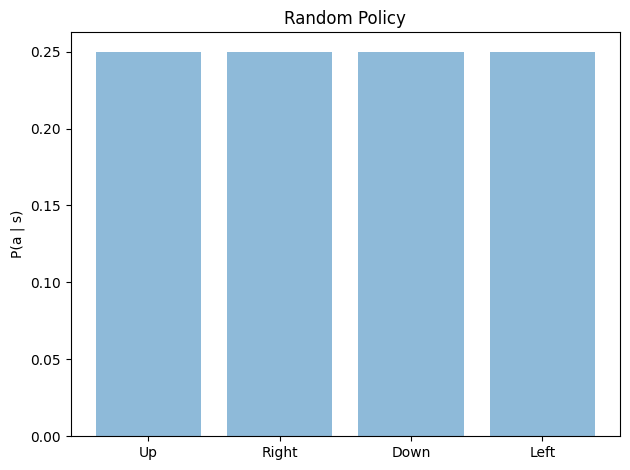

In [32]:
objects = ['Up', 'Right', 'Down', 'Left']
y_pos = np.arange(len(objects))

plt.bar(y_pos, action_probabilities, alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('P(a | s)')
plt.title('Random Policy')
plt.tight_layout()

plt.show()

It took us 882 moves to find the exit,
    and each reward r(s,a)=-1, so the return amounts to -99.98586676321653


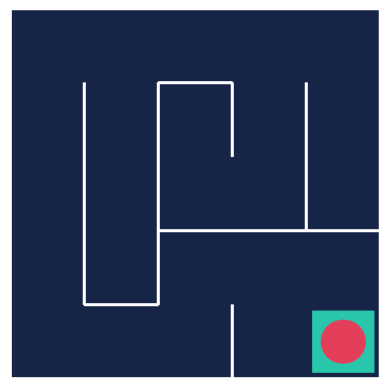

In [35]:
env.reset()
done = False
img = plt.imshow(env.render(mode='rgb_array'))
gamma = 0.99 # 割引価値
G_0 = 0 # return
t = 0 # time

while not done:
  action = np.random.choice(range(4), 1, p=action_probabilities)
  _, reward, done, _ = env.step(action)
  G_0 += gamma ** t * reward
  t +=1
  img.set_data(env.render(mode='rgb_array'))
  plt.axis('off')
  display.display(plt.gcf())
  display.clear_output(wait=True)


print(
    f"""It took us {t} moves to find the exit,
    and each reward r(s,a)=-1, so the return amounts to {G_0}""")